# 1. Import

In [1]:
import warnings
import re
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder, TargetEncoder, JamesSteinEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer, MissingIndicator
from shap import TreeExplainer
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

# 2. Utils

In [3]:
def get_preds_shaps(df, features, target, ix_trn):
  model = LGBMRegressor().fit(df.loc[ix_trn, features], df.loc[ix_trn, target])
  preds = pd.Series(model.predict(df[features]), index=df.index)
  shap_explainer = TreeExplainer(model)
  shaps = pd.DataFrame(
    data=shap_explainer.shap_values(df[features]),
    index=df.index,
    columns=features)
  return preds, shaps

In [4]:
def get_feature_contributions(y_true, y_pred, shap_values):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

  abs_error = (y_true - y_pred).abs()
  y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)
  abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y_true - feature).abs())
  error_contribution = abs_error_wo_feature.apply(lambda feature: abs_error - feature).mean().rename("error_contribution")
      
  return prediction_contribution, error_contribution

# 3. Toy Example

### 3.1 Generate data

In [5]:
shap_values = pd.DataFrame([
  [65,  12,   8],
  [72,   3, -22],
  [78, -23,  15]], columns=["job", "age", "nationality"])
y_pred = shap_values.sum(axis=1).rename("income (predicted)")
y_true = pd.Series([74, 68, 58], name="income (true)")

### 3.2 Compute Prediction Contribution and Error Contribution

In [6]:
abs_error = (y_true - y_pred).abs().rename("absolute error")

prediction_contribution = shap_values.abs().mean().round(2).rename("prediction_contribution").to_frame().T

y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)
abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y_true - feature).abs())
error_diff = abs_error_wo_feature.apply(lambda feature: abs_error - feature)
error_contribution = error_diff.mean().round(2).rename("error_contribution").to_frame().T

### 3.3 Display items

In [7]:
pd.concat([y_true, y_pred, abs_error], axis=1)

,income (true),income (predicted),absolute error
0,74,85,11
1,68,53,15
2,58,70,12


In [8]:
shap_values

,job,age,nationality
0,65,12,8
1,72,3,-22
2,78,-23,15


In [9]:
prediction_contribution

,job,age,nationality
prediction_contribution,71.67,12.67,15.0


In [10]:
y_pred_wo_feature

,job,age,nationality
0,20,73,77
1,-19,50,75
2,-8,93,55


In [11]:
abs_error_wo_feature

,job,age,nationality
0,54,1,3
1,87,18,7
2,66,35,3


In [12]:
error_diff

,job,age,nationality
0,-43,10,8
1,-72,-3,8
2,-54,-23,9


In [13]:
error_contribution

,job,age,nationality
error_contribution,-56.33,-5.33,8.33


# 4. Real dataset

In [14]:
df = get_data("gold", verbose=False)
df *= 100

target = "Gold_T+22"

features = [f for f in df.columns if f != target]
argsort = np.argsort([f.split("T-")[0] + "T-" + "{:2.1f}".format(float(f.split("T-")[1])).zfill(4) for f in features])
features = [features[arg] for arg in argsort]

# 5. Data Analysis

In [15]:
df[target].describe()

count    2558.000000
mean        0.322176
std         4.419812
min       -14.910681
25%        -2.361938
50%         0.144122
75%         3.153245
max        19.472259
Name: Gold_T+22, dtype: float64

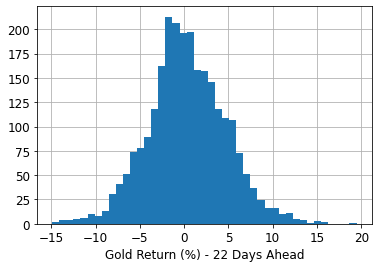

In [16]:
fig, ax = plt.subplots()

ax.hist(df[target], bins="fd")
ax.grid(); ax.set_axisbelow(True)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Gold Return (%) - 22 Days Ahead", fontsize=12)

fig.savefig("target_hist.png", dpi=200, bbox_inches="tight")

In [17]:
pd.set_option('display.max_columns', 8)
pd.set_option("display.max_rows", 5)

df[features + [target]].round(2)

,3M Libor_T-1,3M Libor_T-7,3M Libor_T-14,3M Libor_T-22,...,Yuan_T-7,Yuan_T-14,Yuan_T-22,Gold_T+22
0,0.00,-1.80,-2.90,-4.07,...,-0.01,-0.02,-0.00,0.46
1,-0.46,-1.47,-3.34,-4.51,...,-0.01,-0.04,-0.01,-0.21
...,...,...,...,...,...,...,...,...,...
2556,-0.23,0.02,-1.18,-6.73,...,1.25,1.88,3.98,-2.03
2557,-0.29,-0.83,-1.93,-5.03,...,1.21,2.22,3.46,-2.71


In [18]:
for enum, f in enumerate(sorted(set([f.split("_")[0] for f in features]))):
  print(f.ljust(20), end="")
  if enum % 4 == 3:
    print("\n", end="")

3M Libor            AUD                 Brent 1             Brent 2             
Corn                Crude Palm Oil      DJ Index            Dollex              
EM Bond             EMEquity ETF        Euro Curr           Gold                
INR                 Light Crude         MR                  MSCI APAC ex J      
MSCI EM             Nifty               Nikkei Ind          Palladium           
Platinum            S&P 500             Shanghai Index      Silver              
US Bond ETF         Wheat 1             Wheat 2             White Sugar         
Yuan                

# 6. Train/Validation/Test Split

In [19]:
np.random.seed(123)
fold = np.random.choice(["trn", "val", "tst"], p=[1/3, 1/3, 1/3], size=len(df))

ix_trn = fold == "trn"
ix_val = fold == "val"
ix_tst = fold == "tst"

In [20]:
assert (ix_trn.astype(int) + ix_val.astype(int) + ix_tst.astype(int) == 1).all()

# 7. Single Model

### 7.1 Compute Predictions and Shap Values

In [21]:
preds, shaps = get_preds_shaps(df=df, features=features, target=target, ix_trn=ix_trn)

prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
  y_true=df.loc[ix_trn, target], 
  y_pred=preds.loc[ix_trn], 
  shap_values=shaps.loc[ix_trn, :]
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
  y_true=df.loc[ix_val, target], 
  y_pred=preds.loc[ix_val], 
  shap_values=shaps.loc[ix_val, :]
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

### 7.2 Write/Read Results

In [22]:
contributions_trn.to_csv("contributions_trn.csv", index=True)
contributions_val.to_csv("contributions_val.csv", index=True)

In [23]:
contributions_trn = pd.read_csv("contributions_trn.csv", index_col=0)
contributions_val = pd.read_csv("contributions_val.csv", index_col=0)

### 7.3 Prediction vs. Error Contribution (Training)

In [24]:
contributions_trn

,prediction_contribution,error_contribution
3M Libor_T-1,0.042951,-0.013922
3M Libor_T-7,0.090338,-0.039541
...,...,...
Yuan_T-14,0.066477,-0.028666
Yuan_T-22,0.144774,-0.072751


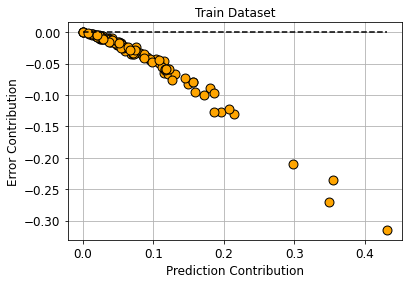

In [25]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(); ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [26]:
pd.set_option("display.max_rows", 10)

contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
INR_T-22,0.431543,-0.314891
EM Bond_T-22,0.354269,-0.234833
3M Libor_T-22,0.349576,-0.270460
Platinum_T-14,0.298751,-0.209640
Shanghai Index_T-22,0.214553,-0.130805
White Sugar_T-22,0.207254,-0.122756
3M Libor_T-14,0.195259,-0.127183
EMEquity ETF_T-7,0.186585,-0.097444
Gold_T-22,0.185994,-0.126613
Brent 2_T-14,0.180668,-0.088183


### 7.4 Prediction vs. Error Contribution (Validation)

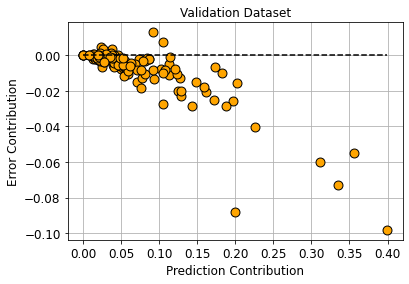

In [27]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [28]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
INR_T-22,0.3997,-0.0982
Gold_T-22,0.1998,-0.0882
3M Libor_T-22,0.3347,-0.0730
Platinum_T-14,0.3117,-0.0599
EM Bond_T-22,0.3559,-0.0552
Shanghai Index_T-22,0.2263,-0.0401
Corn_T-22,0.1876,-0.0283
DJ Index_T-22,0.1426,-0.0283
Brent 1_T-22,0.1046,-0.0273
3M Libor_T-14,0.1977,-0.0257


In [29]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=False).round(4).head(10)

,prediction_contribution,error_contribution
US Bond ETF_T-1,0.0926,0.0130
MSCI APAC ex J_T-1,0.1057,0.0076
MSCI EM_T-1,0.0241,0.0047
Nikkei Ind_T-1,0.0269,0.0038
Corn_T-1,0.0380,0.0033
Brent 1_T-1,0.0264,0.0029
Brent 2_T-1,0.0258,0.0029
DJ Index_T-1,0.0256,0.0019
Euro Curr_T-1,0.0297,0.0014
INR_T-7,0.0371,0.0013


# 8. Recursive Feature Elimination (RFE)

### 8.1. RFE - Error Contribution
At each step, we remove the feature with the highest error contribution.

In [30]:
rfe_error = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
  
  preds, shaps = get_preds_shaps(df=df, features=features_curr, target=target, ix_trn=ix_trn)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true=df.loc[ix_val, target], 
    y_pred=preds.loc[ix_val], 
    shap_values=shaps.loc[ix_val, :]
  )

  rfe_error.loc[iteration, "feature_drop"] = feature_drop
  rfe_error.loc[iteration, "n_features"] = len(features_curr)
  rfe_error.loc[iteration, "contrib"] = error_contribution.max()
  rfe_error.loc[iteration, "mae_trn"] = mean_absolute_error(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_error.loc[iteration, "mae_val"] = mean_absolute_error(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_error.loc[iteration, "mae_tst"] = mean_absolute_error(df.loc[ix_tst, target], preds.loc[ix_tst])
  rfe_error.loc[iteration, "r2_trn"] = r2_score(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_error.loc[iteration, "r2_val"] = r2_score(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_error.loc[iteration, "r2_tst"] = r2_score(df.loc[ix_tst, target], preds.loc[ix_tst])
  
  feature_drop = error_contribution.idxmax()
  features_curr.remove(feature_drop)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [04:09<00:00,  2.08s/it]


### 8.2. RFE - Prediction Contribution
At each step, we remove the feature with the smallest prediction contribution (i.e. the less important feature)

In [31]:
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
  
  preds, shaps = get_preds_shaps(df=df, features=features_curr, target=target, ix_trn=ix_trn)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true=df.loc[ix_val, target], 
    y_pred=preds.loc[ix_val], 
    shap_values=shaps.loc[ix_val, :]
  )

  rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
  rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
  rfe_prediction.loc[iteration, "contrib"] = prediction_contribution.min()
  rfe_prediction.loc[iteration, "mae_trn"] = mean_absolute_error(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_prediction.loc[iteration, "mae_val"] = mean_absolute_error(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_prediction.loc[iteration, "mae_tst"] = mean_absolute_error(df.loc[ix_tst, target], preds.loc[ix_tst])
  rfe_prediction.loc[iteration, "r2_trn"] = r2_score(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_prediction.loc[iteration, "r2_val"] = r2_score(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_prediction.loc[iteration, "r2_tst"] = r2_score(df.loc[ix_tst, target], preds.loc[ix_tst])
  
  feature_drop = prediction_contribution.idxmin()
  features_curr.remove(feature_drop)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [04:10<00:00,  2.08s/it]


### 8.3 Write Results

In [32]:
rfe_error.to_csv("gold_rfe_error.csv", index=False)
rfe_prediction.to_csv("gold_rfe_prediction.csv", index=False)

### 8.4 Read Results

In [33]:
rfe_error = pd.read_csv("gold_rfe_error.csv")
rfe_prediction = pd.read_csv("gold_rfe_prediction.csv")

### 8.5 Plot RFE on Validation

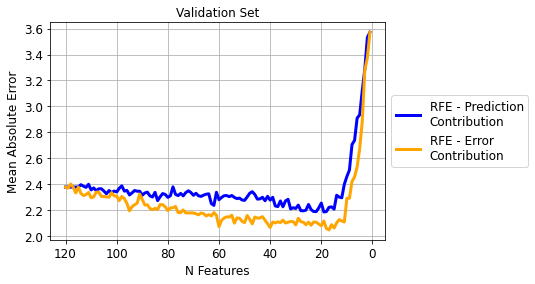

In [34]:
fig, ax = plt.subplots()

ax.plot(-rfe_prediction["n_features"], rfe_prediction["mae_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error["n_features"], rfe_error["mae_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_val_all.png", dpi=200, bbox_inches="tight")

### 8.6 Plot RFE on Training

In [35]:
max_iter_show = len(rfe_error) - 9

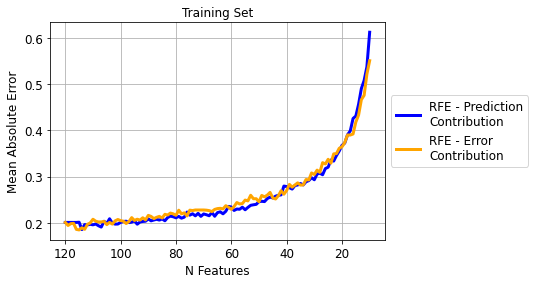

In [36]:
fig, ax = plt.subplots()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_trn"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_trn"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.set_title("Training Set")
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_trn.png", dpi=200, bbox_inches="tight")

### 8.7 Plot RFE on Validation

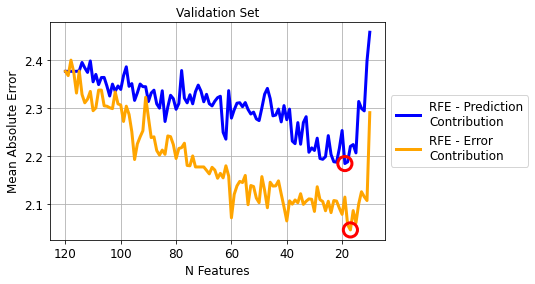

In [37]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["mae_val"].idxmin()
idxmin_error = rfe_error["mae_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"mae_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"mae_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_val.png", dpi=200, bbox_inches="tight")

In [38]:
rfe_error.sort_values("mae_val", ascending=True).head(1)

,feature_drop,n_features,contrib,mae_trn,...,mae_tst,r2_trn,r2_val,r2_tst
103,Nikkei Ind_T-22,17.0,-0.034201,0.389733,...,1.940193,0.98585,0.642669,0.605735


In [39]:
rfe_prediction.sort_values("mae_val", ascending=True).head(1)

,feature_drop,n_features,contrib,mae_trn,...,mae_tst,r2_trn,r2_val,r2_tst
101,Brent 2_T-14,19.0,0.254594,0.372378,...,2.04357,0.986542,0.594444,0.582419


### 8.8 Plot RFE on Test

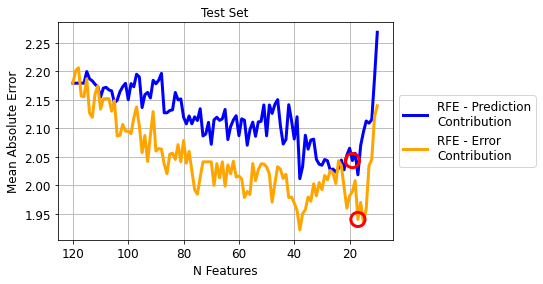

In [40]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["mae_val"].idxmin()
idxmin_error = rfe_error["mae_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_tst"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_tst"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"mae_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"mae_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Test Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_tst.png", dpi=200, bbox_inches="tight")